In [1]:
import torch
from torch import nn
import torchvision

print(f"Pytorch version:{torch.__version__}\n torchvision version:{torchvision.__version__}")

Pytorch version:2.2.1+cu121
 torchvision version:0.17.1+cu121


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(), # 转换为张量
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 归一化
])

# 加载 CIFAR-10 数据集
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 打印数据集大小
print('训练集大小:', len(train_dataset))
print('验证集大小:', len(val_dataset))
print('测试集大小:', len(test_dataset))

# 打印类别标签
classes = dataset.classes
print('类别标签:', classes)

#数据集查看
image, label = train_dataset[0]

# image, label #查看第一条训练数据
image.shape  #查看数据的形状


训练集大小: 40000
验证集大小: 10000
测试集大小: 10000
类别标签: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: (3, 32, 32)


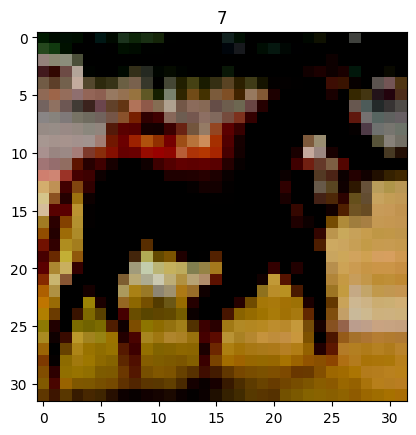

In [3]:
import matplotlib.pyplot as plt
import numpy as np

image, label = train_dataset[0]

# 确保图像数据类型为 NumPy 数组
image = np.array(image)

# 显示图像
print(f"Image shape: {image.shape}")
plt.imshow(image.transpose(1, 2, 0))
plt.title(label)
plt.show()

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# 定义训练函数
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    losses = []
    model.to(device)
    for epoch in range(num_epochs):
        model.train()  # 设置模型为训练模式
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # 梯度清零
            outputs = model(inputs)  # 前向传播
            loss = criterion(outputs, labels)  # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 参数更新
            running_loss += loss.item()
            losses.append(loss.item())

        # 打印每个epoch的训练损失
        print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}")

        # 在验证集上评估模型
        model.eval()  # 设置模型为评估模式
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():  # 不计算梯度
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # 打印每个epoch的验证损失和准确率
        print(f"Epoch {epoch+1}, Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {(correct/total)*100:.2f}%")
        count = 0
        # if (correct/total) > 0.80:
        #     count = count + 1
        # if count >= 3:
        #     break

    return losses

In [ ]:
def test_data(model, test_loader, criterion):
    model.to(device)
    model.eval()  # 设置模型为评估模式
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # 不计算梯度
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Loss: {test_loss/len(test_loader)}, Test Accuracy: {(correct/total)*100:.2f}%")
    

In [6]:
from torch.utils.data import DataLoader, random_split

# 设置批处理大小超参数
BATCH_SIZE = 64

# 定义数据加载器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

#打印结果
print(f"Dataloaders: {train_loader, test_loader}")
print(f"Length of 训练集: {len(train_loader)}, batches of {BATCH_SIZE}")
print(f"Length of 验证集: {len(val_loader)}, batches of {BATCH_SIZE}")
print(f"Length of 测试集: {len(test_loader)}, batches of {BATCH_SIZE}")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001B60CC4B3D0>, <torch.utils.data.dataloader.DataLoader object at 0x000001B60CCAB5D0>)
Length of 训练集: 625, batches of 64
Length of 验证集: 157, batches of 64
Length of 测试集: 157, batches of 64


## Resnet9

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride

        # For shortcut connection
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Shortcut connection
        residual = self.shortcut(residual)

        out += residual
        out = self.relu(out)

        return out

class ResNet9(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet9, self).__init__()
        self.prep = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = self._make_layer(64, 128, stride=1)
        self.layer2 = self._make_layer(128, 256, stride=2)
        self.layer3 = self._make_layer(256, 512, stride=2)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(512, num_classes, kernel_size=1)
        )

    def _make_layer(self, in_channels, out_channels, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.prep(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.classifier(out)
        out = out.view(out.size(0), -1)
        return F.log_softmax(out, dim=1)

# 创建 ResNet-9 模型实例
resnet9 = ResNet9()
# 打印模型结构
print(resnet9)


ResNet9(
  (prep): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (layer2): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   

In [9]:
import torch.optim as optim

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()   
optimizer = optim.SGD(resnet9.parameters(), lr=0.01, momentum=0.9, nesterov=True)
# optimizer = optim.Adam(model_Res.parameters(), lr=0.001)

val_losses = train_model(resnet9, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Epoch 1, Train Loss: 1.3068763389587403
Epoch 1, Validation Loss: 1.2370467334036614, Validation Accuracy: 54.56%
Epoch 2, Train Loss: 0.9089806944847106
Epoch 2, Validation Loss: 0.8895441980878259, Validation Accuracy: 68.95%
Epoch 3, Train Loss: 0.7282590817451478
Epoch 3, Validation Loss: 0.7515919016804665, Validation Accuracy: 73.65%
Epoch 4, Train Loss: 0.6010240538597107
Epoch 4, Validation Loss: 0.7806165829585616, Validation Accuracy: 73.27%
Epoch 5, Train Loss: 0.5009850335836411
Epoch 5, Validation Loss: 0.7808399010615744, Validation Accuracy: 74.53%
Epoch 6, Train Loss: 0.40948437273502347
Epoch 6, Validation Loss: 0.8692299919143603, Validation Accuracy: 72.05%
Epoch 7, Train Loss: 0.33366934468746184
Epoch 7, Validation Loss: 0.710957637258396, Validation Accuracy: 76.13%
Epoch 8, Train Loss: 0.25679034032821657
Epoch 8, Validation Loss: 0.7796242531317814, Validation Accuracy: 76.36%
Epoch 9, Train Loss: 0.19029173107743264
Epoch 9, Validation Loss: 0.7914146923335494,

In [10]:
test_data(model=resnet9, test_loader=test_loader, criterion=criterion)

Test Loss: 0.7202756092616707, Test Accuracy: 84.11%


## Resnet

In [41]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=stride, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        # 保存输入 x 作为恒等映射（identity），用于在残差连接中与输出相加
        identity = x

        # 第一个卷积层的前向传播
        out = self.conv1(x)
        # 对第一个卷积层的输出进行批量归一化
        out = self.bn1(out)
        # 对批量归一化后的结果应用 ReLU 激活函数
        out = self.relu(out)

        # 第二个卷积层的前向传播
        out = self.conv2(out)
        # 对第二个卷积层的输出进行批量归一化
        out = self.bn2(out)

        # 如果存在 downsample（残差连接中的下采样操作），则对输入 x 进行下采样
        if self.downsample is not None:
            identity = self.downsample(x)

        # 将残差连接的结果与输入相加
        out += identity
        # 对相加后的结果应用 ReLU 激活函数
        out = self.relu(out)

        # 返回最终的输出
        return out

class CNN_ResNet(nn.Module):
    def __init__(self, num_classes=10):
        # 调用父类（nn.Module）的构造函数，初始化模型的基本结构
        super(CNN_ResNet, self).__init__()

        # 第一个卷积块，包括一个卷积层、ReLU 激活函数和最大池化层
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),  # 输入通道为 3，输出通道为 16，卷积核大小为 5x5，填充为 2
            nn.ReLU(),  # ReLU 激活函数
            nn.MaxPool2d(kernel_size=2)  # 最大池化层，池化核大小为 2x2
        )

        # 使用 make_layer 方法构建第二、第三和第四个残差块
        self.conv2 = self.make_layer(16, 32, stride=1)  # 构建残差块，输入通道为 16，输出通道为 32，步长为 1
        self.conv3 = self.make_layer(32, 64, stride=1)  # 构建残差块，输入通道为 32，输出通道为 64，步长为 1
        self.conv4 = self.make_layer(64, 128, stride=1)  # 构建残差块，输入通道为 64，输出通道为 128，步长为 1

        # 全局平均池化层，将特征图大小调整为 (1, 1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # 全连接层，将最后一层特征图压缩为长度为 num_classes 的向量，用于分类
        self.fc = nn.Linear(128, num_classes)  # 输入大小为 128，输出大小为分类类别数

    def make_layer(self, in_channels, out_channels, stride):
        # 初始化 downsample 为 None，用于存储下采样操作
        downsample = None
        # 如果步长不为 1 或者输入通道数不等于输出通道数，则需要进行下采样操作
        if stride != 1 or in_channels != out_channels:
            # 构建下采样操作，包括一个卷积层和一个批量归一化层
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        # 初始化残差块层列表
        layers = []
        # 将构建好的残差块添加到列表中
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
        # 将列表转换为序列，并返回
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [51]:
import torch.optim as optim

model_Res = CNN_ResNet()
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()   
optimizer = optim.SGD(model_Res.parameters(), lr=0.01, momentum=0.9, nesterov=True)
# optimizer = optim.Adam(model_Res.parameters(), lr=0.001)

val_losses = train_model(model_Res, train_loader, val_loader, criterion, optimizer, num_epochs=30)

Epoch 1, Train Loss: 1.3340047006607056
Epoch 1, Validation Loss: 1.1853217399044402, Validation Accuracy: 57.19%
Epoch 2, Train Loss: 0.9775206230163574
Epoch 2, Validation Loss: 1.067211603283123, Validation Accuracy: 62.39%
Epoch 3, Train Loss: 0.8248997010231018
Epoch 3, Validation Loss: 0.933307798045456, Validation Accuracy: 67.50%
Epoch 4, Train Loss: 0.7204245248317719
Epoch 4, Validation Loss: 0.8753282816926385, Validation Accuracy: 69.66%
Epoch 5, Train Loss: 0.6401915470600128
Epoch 5, Validation Loss: 0.7141675546670415, Validation Accuracy: 75.36%
Epoch 6, Train Loss: 0.5754885333776474
Epoch 6, Validation Loss: 0.6828022587830853, Validation Accuracy: 76.99%
Epoch 7, Train Loss: 0.5265835210323334
Epoch 7, Validation Loss: 0.6559085435928054, Validation Accuracy: 77.52%
Epoch 8, Train Loss: 0.4808338764667511
Epoch 8, Validation Loss: 0.6699856980970711, Validation Accuracy: 77.75%
Epoch 9, Train Loss: 0.43991200037002565
Epoch 9, Validation Loss: 0.7366440074079356, Val

In [53]:
test_data(model=model_Res, test_loader=test_loader, criterion=criterion)

Test Loss: 0.8757081992307286, Test Accuracy: 80.93%


## CNN

In [ ]:
import torch.nn.functional as F

'''开始建立CNN网络'''
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        '''
        一般来说，卷积网络包括以下内容：
        1.卷积层
        2.神经网络
        3.池化层
        '''
        self.conv1=nn.Sequential(
            nn.Conv2d(              #--> (3, 32, 32)
                in_channels=3,      #传入RGB为三层
                out_channels=16,    #输出的图片是几层
                kernel_size=5,      #代表扫描的区域点为3*3
                stride=1,           #就是每隔多少步跳一下
                padding=2,          #边框补全，其计算公式=（kernel_size-1）/2=(5-1)/2=2
            ),    # 2d代表二维卷积           --> (16, 32, 32)
            nn.ReLU(),              #非线性激活层
            nn.MaxPool2d(kernel_size=2),    #设定这里的扫描区域为2*2，且取出该2*2中的最大值          --> (16, 16, 16)
        )
 
        self.conv2=nn.Sequential(
            nn.Conv2d(              #       --> (16, 16, 16)
                in_channels=16,     #这里的输入是上层的输出为16层
                out_channels=32,    #在这里我们需要将其输出为32层
                kernel_size=5,      #代表扫描的区域点为5*5
                stride=1,           #就是每隔多少步跳一下
                padding=2,          #边框补全，其计算公式=（kernel_size-1）/2=(5-1)/2=
            ),                      #   --> (32, 16, 16)
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2),    #设定这里的扫描区域为2*2，且取出该2*2中的最大值     --> (32, 8, 8)，这里是三维数据
        )

        self.conv3=nn.Sequential(
            nn.Conv2d(              #       --> (32, 16, 16)
                in_channels=32,     #这里的输入是上层的输出为32层
                out_channels=64,    #在这里我们需要将其输出为64层
                kernel_size=3,      #代表扫描的区域点为3*3
                stride=1,           #就是每隔多少步跳一下
                padding=1,          #边框补全，其计算公式=（kernel_size-1）/2=(3-1)/2=
            ),                      #   --> (64, 16, 16)
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2),    #设定这里的扫描区域为2*2，且取出该2*2中的最大值     --> (64, 4, 4)，这里是三维数据
        )

        self.conv4=nn.Sequential(
            nn.Conv2d(              #       --> (64, 16, 16)
                in_channels=64,     #这里的输入是上层的输出为64层
                out_channels=128,    #在这里我们需要将其输出为128层
                kernel_size=5,      #代表扫描的区域点为3*3
                stride=1,           #就是每隔多少步跳一下
                padding=2,          #边框补全，其计算公式=（kernel_size-1）/2=(3-1)/2=
            ),                      #   --> (128, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),    #设定这里的扫描区域为2*2，且取出该2*2中的最大值     --> (128, 16, 16)，这里是三维数据
        )
 
        self.out=nn.Linear(128*8*8,10)       #注意一下这里的数据是二维的数据
 
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)     #（batch,32, 8, 8）
        x=self.conv3(x)
        x=self.conv4(x)
        #然后接下来进行一下扩展展平的操作，将三维数据转为二维的数据
        x=x.view(x.size(0),-1)    
        x=self.out(x)
        return x



In [23]:
import torch.optim as optim

# 创建模型实例                                                                                                                                      
model = CNN()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()   
optimizer = optim.SGD(lr=0.01, momentum=0.9, nesterov=True)

# 训练模型
val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

Epoch 1, Train Loss: 1.4688179598808289
Epoch 1, Validation Loss: 1.1913261516079021, Validation Accuracy: 57.57%
Epoch 2, Train Loss: 1.0878320751190185
Epoch 2, Validation Loss: 1.0254249754984668, Validation Accuracy: 63.75%
Epoch 3, Train Loss: 0.893797371006012
Epoch 3, Validation Loss: 0.9689578797407211, Validation Accuracy: 67.02%
Epoch 4, Train Loss: 0.7628002008914948
Epoch 4, Validation Loss: 0.8564041983929409, Validation Accuracy: 70.35%
Epoch 5, Train Loss: 0.6545688506603241
Epoch 5, Validation Loss: 0.8229674750072941, Validation Accuracy: 71.97%
Epoch 6, Train Loss: 0.5655449935913086
Epoch 6, Validation Loss: 0.8476263821884326, Validation Accuracy: 72.51%
Epoch 7, Train Loss: 0.48239095149040223
Epoch 7, Validation Loss: 0.8816279083680195, Validation Accuracy: 72.61%
Epoch 8, Train Loss: 0.3958609107851982
Epoch 8, Validation Loss: 0.9618259679739642, Validation Accuracy: 71.51%
Epoch 9, Train Loss: 0.33020731328725816
Epoch 9, Validation Loss: 1.0576021101824038, V

In [24]:
# 测试集
# 在验证集上评估模型
model.eval()  # 设置模型为评估模式
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():  # 不计算梯度
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Loss: {test_loss/len(test_loader)}, Test Accuracy: {(correct/total)*100:.2f}%")

Test Loss: 1.1159870229708921, Test Accuracy: 70.29%
